# Enhanced Imaging with Aurora SDK

This notebook demonstrates Aurora's Enhanced Imaging capabilities, which leverage built-in Deep Neural Network (DNN) models to perform advanced computer vision tasks.

## What is Enhanced Imaging?

Aurora's Enhanced Imaging system uses onboard AI acceleration to provide:

### 🎯 **Advanced Stereo Depth Sensing**
- High-quality depth maps using AI-enhanced stereo vision
- Dense 3D point clouds with improved accuracy
- Real-time depth estimation at camera frame rate

### 🧠 **Semantic Segmentation**
- Pixel-wise scene understanding using DNN models
- Real-time object and scene classification
- Multiple label sets for different applications


### Multiple Model Support

To meet the needs of different applications, Aurora supports two sets of segmentation models:

#### **Default Model**
- Optimized for general **indoor applications**
- Supports **80 classes** based on COCO dataset
- Ideal for indoor navigation, object detection, and general-purpose robotics

#### **Alternative Model**  
- Optimized for **outdoor applications**
- Supports **18 classes** based on Cityscapes dataset
- Designed for outdoor navigation, autonomous vehicles, and street-level applications

The system allows runtime switching between models, enabling applications to adapt their perception capabilities based on the current environment or task requirements. Label information can be retrieved using the Enhanced Imaging APIs, and background pixels are indicated by "(null)" labels.

### 🔗 **Multi-Modal Data Correlation**
- Timestamp-synchronized depth, segmentation, and camera data
- Rectified pixel alignment for precise correlation
- 3D semantic understanding through depth-segmentation fusion

## Applications

- **Autonomous Navigation**: Object detection and avoidance
- **3D Scene Understanding**: Semantic mapping of environments
- **Safety Systems**: Real-time hazard detection
- **Robotics**: Manipulation and interaction planning
- **Augmented Reality**: Context-aware content placement


Let's explore these capabilities step by step!

## Setup and Imports

In [55]:
# Core imports
from slamtec_aurora_sdk import AuroraSDK
from slamtec_aurora_sdk.exceptions import DataNotReadyError
import numpy as np
import time
import math
from collections import deque

# Image processing
try:
    import cv2
    OPENCV_AVAILABLE = True
    print("✅ OpenCV available for image processing")
    print(f"   OpenCV version: {cv2.__version__}")
except ImportError:
    OPENCV_AVAILABLE = False
    print("⚠️ OpenCV not available. Install with: pip install opencv-python")

# Visualization
try:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.patches as patches
    from matplotlib.colors import ListedColormap
    MATPLOTLIB_AVAILABLE = True
    print("✅ Matplotlib available for visualization")
    
    # Configure matplotlib for notebook
    try:
        # This will work in Jupyter notebooks
        get_ipython().run_line_magic('matplotlib', 'inline')
    except:
        # Fallback for regular Python execution
        pass
    plt.rcParams['figure.figsize'] = (15, 10)
except ImportError:
    MATPLOTLIB_AVAILABLE = False
    print("⚠️ Matplotlib not available. Install with: pip install matplotlib")

# 3D visualization (optional)
try:
    import open3d as o3d
    OPEN3D_AVAILABLE = True
    print("✅ Open3D available for 3D visualization")
    print(f"   Open3D version: {o3d.__version__}")
except ImportError:
    OPEN3D_AVAILABLE = False
    print("⚠️ Open3D not available. Install with: pip install open3d")

# Scientific computing (optional)
try:
    from scipy.spatial.distance import cdist
    from scipy import ndimage
    SCIPY_AVAILABLE = True
    print("✅ SciPy available for advanced processing")
except ImportError:
    SCIPY_AVAILABLE = False
    print("⚠️ SciPy not available (optional for advanced processing)")

print("\n🚀 Enhanced Imaging notebook ready!")
print(f"Required libraries: {'✅' if OPENCV_AVAILABLE else '❌'} OpenCV, {'✅' if MATPLOTLIB_AVAILABLE else '❌'} Matplotlib")
print(f"Optional libraries: {'✅' if OPEN3D_AVAILABLE else '❌'} Open3D, {'✅' if SCIPY_AVAILABLE else '❌'} SciPy")

✅ OpenCV available for image processing
   OpenCV version: 4.11.0
✅ Matplotlib available for visualization
✅ Open3D available for 3D visualization
   Open3D version: 0.19.0
⚠️ SciPy not available (optional for advanced processing)

🚀 Enhanced Imaging notebook ready!
Required libraries: ✅ OpenCV, ✅ Matplotlib
Optional libraries: ✅ Open3D, ❌ SciPy


## Step 1: Connect to Device and Enable Enhanced Imaging

Let's connect to Aurora and enable the Enhanced Imaging features.

In [57]:
# Device connection
device_ip = "192.168.11.1"  # Replace with your device IP

sdk = AuroraSDK()

try:
    print(f"Connecting to Aurora device at {device_ip}...")
    sdk.connect(connection_string=device_ip)
    print("✅ Connected successfully!")
    
    # Get device info
    try:
        device_info = sdk.get_device_info()
        print(f"📱 Device: {device_info.device_name} ({device_info.device_model_string})")
    except Exception as e:
        print(f"⚠️ Could not get device info: {e}")
    
    # Check Enhanced Imaging support
    try:
        device_basic_info = sdk.data_provider.get_last_device_basic_info()
        
        if device_basic_info.isSupportEnhancedImaging():
            print("✅ Enhanced Imaging supported")
        else:
            print("⚠️ Enhanced Imaging may not be supported")
        
        # Check specific capabilities
        print("\n🔍 Enhanced Imaging Capabilities:")
        print(f"  Depth Camera: {'✅' if device_basic_info.isSupportDepthCamera() else '❌'}")
        print(f"  Semantic Segmentation: {'✅' if device_basic_info.isSupportSemanticSegmentation() else '❌'}")
    except Exception as e:
        print(f"⚠️ Could not check Enhanced Imaging capabilities: {e}")
    
    # Access Enhanced Imaging component
    if hasattr(sdk, 'enhanced_imaging'):
        print("\n📷 Enhanced Imaging component available")
        
        # Import Enhanced Imaging constants
        try:
            from slamtec_aurora_sdk.data_types import ENHANCED_IMAGE_TYPE_DEPTH, ENHANCED_IMAGE_TYPE_SEMANTIC_SEGMENTATION
            
            print("🔄 Enabling depth camera subscription...")
            sdk.controller.set_enhanced_imaging_subscription(ENHANCED_IMAGE_TYPE_DEPTH, True)
            
            print("🔄 Enabling semantic segmentation subscription...")
            sdk.controller.set_enhanced_imaging_subscription(ENHANCED_IMAGE_TYPE_SEMANTIC_SEGMENTATION, True)
            
            print("✅ Enhanced Imaging subscriptions enabled")
            
            # Wait for data to be ready
            print("⏳ Waiting for Enhanced Imaging data...")
            time.sleep(3)
            
            # Check readiness
            try:
                depth_ready = sdk.enhanced_imaging.is_depth_camera_ready()
                seg_ready = sdk.enhanced_imaging.is_semantic_segmentation_ready()
                
                print(f"  Depth camera ready: {'✅' if depth_ready else '⏳'}")
                print(f"  Semantic segmentation ready: {'✅' if seg_ready else '⏳'}")
            except Exception as e:
                print(f"  ⚠️ Could not check readiness: {e}")
            
        except ImportError as e:
            print(f"❌ Failed to import Enhanced Imaging constants: {e}")
        except Exception as e:
            print(f"❌ Failed to enable Enhanced Imaging subscriptions: {e}")
        
    else:
        print("❌ Enhanced Imaging component not available")
        print("   This may require SDK 2.0 and compatible device firmware")
        
except Exception as e:
    print(f"❌ Connection failed: {e}")
    print("Please check your device IP and network connection.")
    print("\n💡 Debug tips:")
    print("   - Ensure device is powered on and connected to network")
    print("   - Verify IP address is correct")
    print("   - Check firewall settings")

Connecting to Aurora device at 192.168.1.212...
✅ Connected successfully!
📱 Device: Aurora (A1M1)
✅ Enhanced Imaging supported

🔍 Enhanced Imaging Capabilities:
  Depth Camera: ✅
  Semantic Segmentation: ✅

📷 Enhanced Imaging component available
🔄 Enabling depth camera subscription...
🔄 Enabling semantic segmentation subscription...
✅ Enhanced Imaging subscriptions enabled
⏳ Waiting for Enhanced Imaging data...
  Depth camera ready: ✅
  Semantic segmentation ready: ✅


## Step 2: Retrieve and Visualize Depth Maps

Let's capture depth maps from Aurora's AI-enhanced stereo vision system.

📷 Capturing depth map...
✅ Depth frame: 320x224
📊 Valid pixels: 71,569 (99.8%)
  Depth range: 0.2-5.3 m


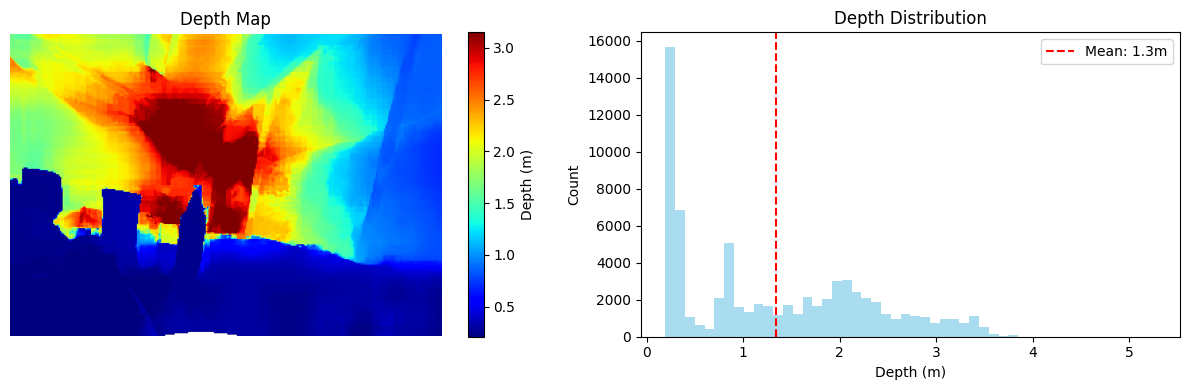

In [58]:
if not (sdk.is_connected() and hasattr(sdk, 'enhanced_imaging')):
    print("❌ Enhanced Imaging not available")
else:
    try:
        print("📷 Capturing depth map...")
        
        # Wait for depth frame
        if sdk.enhanced_imaging.wait_depth_camera_next_frame(5000):
            depth_frame = sdk.enhanced_imaging.peek_depth_camera_frame()
            if depth_frame:
                print(f"✅ Depth frame: {depth_frame.width}x{depth_frame.height}")
                
                # Convert to numpy array
                depth_map = depth_frame.to_numpy_depth_map()
                valid_mask = (depth_map > 0) & np.isfinite(depth_map)
                valid_depths = depth_map[valid_mask]
                
                print(f"📊 Valid pixels: {len(valid_depths):,} ({len(valid_depths)/depth_map.size*100:.1f}%)")
                if len(valid_depths) > 0:
                    print(f"  Depth range: {valid_depths.min():.1f}-{valid_depths.max():.1f} m")
                    
                    # Simple visualization
                    if MATPLOTLIB_AVAILABLE:
                        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                        
                        # Depth map
                        depth_vis = depth_map.copy().astype(np.float32)
                        depth_vis[~valid_mask] = np.nan
                        vmin, vmax = np.percentile(valid_depths, [5, 95])
                        
                        im = ax1.imshow(depth_vis, cmap='jet', vmin=vmin, vmax=vmax)
                        ax1.set_title('Depth Map')
                        ax1.axis('off')
                        plt.colorbar(im, ax=ax1, label='Depth (m)')
                        
                        # Depth histogram
                        ax2.hist(valid_depths, bins=50, alpha=0.7, color='skyblue')
                        ax2.axvline(valid_depths.mean(), color='red', linestyle='--', 
                                   label=f'Mean: {valid_depths.mean():.1f}m')
                        ax2.set_xlabel('Depth (m)')
                        ax2.set_ylabel('Count')
                        ax2.set_title('Depth Distribution')
                        ax2.legend()
                        
                        plt.tight_layout()
                        plt.show()
                
                # Store for later use
                current_depth_frame = depth_frame
                current_depth_map = depth_map
                
    except Exception as e:
        print(f"❌ Depth capture error: {e}")

## Step 3: Retrieve and Visualize 3D Point Clouds

Get dense 3D point clouds directly from Aurora's Enhanced Imaging system.

🌐 Generating 3D point cloud...
🔍 Trying to get POINT3D frame type...
⚠️ Device does not support point3d frame type
🔄 Falling back to depth map frame type...
✅ Got depth map frame: 320x224
📋 Depth data size: 286720 bytes
✅ Got camera calibration data
⚠️ Could not get camera calibration: 'CameraCalibrationInfo' object has no attribute 'left_camera'
📋 Using estimated camera parameters
📋 Depth map shape: (224, 320)
✅ Generated 71,569 3D points from depth map
📊 Distance range: 0.59 - 5.02 meters
📊 X range: -2.81 - 0.78
📊 Y range: -0.75 - 1.27


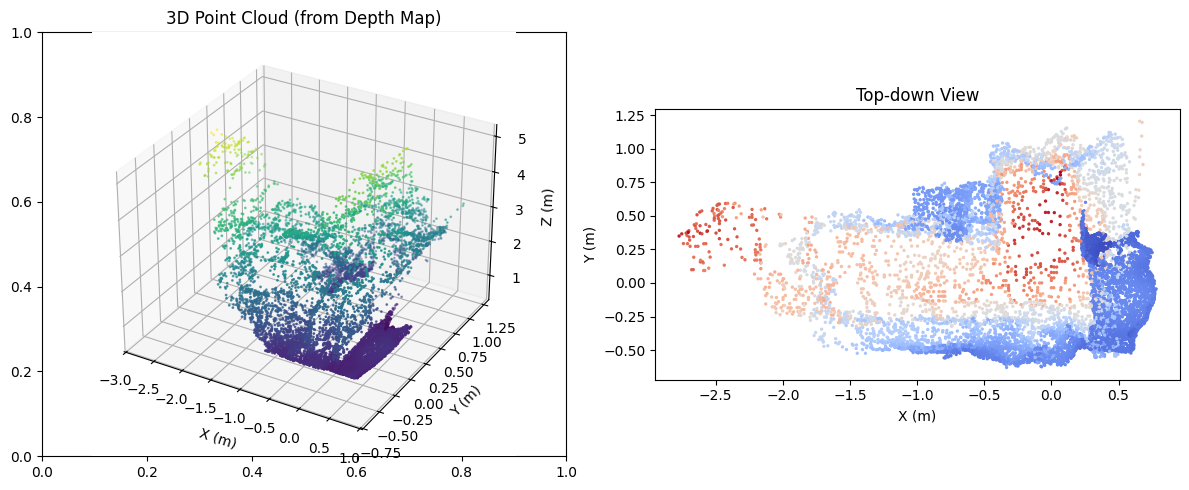

In [126]:
if not (current_depth_frame and OPENCV_AVAILABLE):
    print("⚠️ Point cloud generation skipped - missing depth data or OpenCV")
else:
    try:
        print("🌐 Generating 3D point cloud...")
        
        # Import the required constants
        from slamtec_aurora_sdk.data_types import DEPTHCAM_FRAME_TYPE_POINT3D, DEPTHCAM_FRAME_TYPE_DEPTH_MAP
        
        # First try point3d frame type
        if sdk.enhanced_imaging.wait_depth_camera_next_frame(5000):
            print("🔍 Trying to get POINT3D frame type...")
            point_cloud_frame = sdk.enhanced_imaging.peek_depth_camera_frame(DEPTHCAM_FRAME_TYPE_POINT3D)
            
            if point_cloud_frame and hasattr(point_cloud_frame, 'point3d_data'):
                print("✅ Device supports point3d data directly")
                # Handle point3d data (code would go here)
            else:
                print("⚠️ Device does not support point3d frame type")
                print("🔄 Falling back to depth map frame type...")
                
                # Try depth map frame type instead
                depth_frame = sdk.enhanced_imaging.peek_depth_camera_frame(DEPTHCAM_FRAME_TYPE_DEPTH_MAP)
                
                if depth_frame and hasattr(depth_frame, 'depth_data') and depth_frame.depth_data:
                    print(f"✅ Got depth map frame: {depth_frame.width}x{depth_frame.height}")
                    print(f"📋 Depth data size: {len(depth_frame.depth_data)} bytes")
                    
                    # Get camera calibration for proper 3D projection
                    try:
                        calibration = sdk.data_provider.get_camera_calibration()
                        print("✅ Got camera calibration data")
                        
                        # Use actual camera intrinsics
                        fx = calibration.left_camera.fx
                        fy = calibration.left_camera.fy  
                        cx = calibration.left_camera.cx
                        cy = calibration.left_camera.cy
                        
                        print(f"📋 Camera intrinsics: fx={fx:.1f}, fy={fy:.1f}, cx={cx:.1f}, cy={cy:.1f}")
                        
                    except Exception as calib_e:
                        print(f"⚠️ Could not get camera calibration: {calib_e}")
                        print("📋 Using estimated camera parameters")
                        
                        # Use reasonable estimates for Aurora camera
                        width = depth_frame.width
                        height = depth_frame.height
                        fx = fy = width * 0.7  # Conservative estimate
                        cx = width / 2.0
                        cy = height / 2.0
                    
                    # Convert depth map to point cloud
                    try:
                        depth_map = depth_frame.to_numpy_depth_map()
                        if depth_map is not None:
                            print(f"📋 Depth map shape: {depth_map.shape}")
                            
                            # Create coordinate grids
                            import numpy as np
                            height, width = depth_map.shape
                            u, v = np.meshgrid(np.arange(width), np.arange(height))
                            
                            # Get valid depth values
                            valid_mask = (depth_map > 0) & np.isfinite(depth_map) & (depth_map < 10.0)
                            
                            if np.any(valid_mask):
                                # Get valid coordinates and depths
                                u_valid = u[valid_mask]
                                v_valid = v[valid_mask]
                                z_valid = depth_map[valid_mask]
                                
                                # Project to 3D using camera intrinsics
                                x_valid = (u_valid - cx) * z_valid / fx
                                y_valid = (v_valid - cy) * z_valid / fy
                                
                                # Combine into point cloud
                                points_3d = np.column_stack([x_valid, y_valid, z_valid])
                                
                                print(f"✅ Generated {len(points_3d):,} 3D points from depth map")
                                print(f"📊 Distance range: {z_valid.min():.2f} - {z_valid.max():.2f} meters")
                                print(f"📊 X range: {x_valid.min():.2f} - {x_valid.max():.2f}")
                                print(f"📊 Y range: {y_valid.min():.2f} - {y_valid.max():.2f}")
                                
                                # Simple visualization
                                if MATPLOTLIB_AVAILABLE:
                                    # Subsample for visualization
                                    if len(points_3d) > 10000:
                                        indices = np.random.choice(len(points_3d), 10000, replace=False)
                                        points_vis = points_3d[indices]
                                    else:
                                        points_vis = points_3d
                                    
                                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                                    
                                    # 3D scatter plot
                                    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
                                    distances = np.linalg.norm(points_vis, axis=1)
                                    scatter = ax1.scatter(points_vis[:, 0], points_vis[:, 1], points_vis[:, 2], 
                                                        c=distances, cmap='viridis', s=1)
                                    ax1.set_xlabel('X (m)')
                                    ax1.set_ylabel('Y (m)')
                                    ax1.set_zlabel('Z (m)')
                                    ax1.set_title('3D Point Cloud (from Depth Map)')
                                    
                                    # Top-down view
                                    ax2.scatter(points_vis[:, 0], points_vis[:, 1], c=points_vis[:, 2], 
                                              cmap='coolwarm', s=2)
                                    ax2.set_xlabel('X (m)')
                                    ax2.set_ylabel('Y (m)')
                                    ax2.set_title('Top-down View')
                                    ax2.set_aspect('equal')
                                    
                                    plt.tight_layout()
                                    plt.show()
                                
                                # Store for later use
                                current_point_cloud = points_3d
                                
                            else:
                                print("❌ No valid depth values found in depth map")
                        else:
                            print("❌ Failed to convert depth frame to numpy array")
                    except Exception as e:
                        print(f"❌ Depth map processing failed: {e}")
                else:
                    print("❌ No depth map frame available")
        else:
            print("❌ Timeout waiting for depth camera frame")
                
    except Exception as e:
        print(f"❌ Point cloud generation error: {e}")
        import traceback
        traceback.print_exc()

## Step 4: Retrieve and Visualize Semantic Segmentation

Capture semantic segmentation maps using Aurora's onboard AI models.

🧠 Capturing semantic segmentation...
🏷️ Model: coco80 (81 classes)
✅ Segmentation frame: 640x480
⚠️ Could not get timestamp-correlated preview: DataProvider.get_camera_preview() takes 1 positional argument but 2 were given
⚠️ Using current preview as fallback
📊 Detected 6 classes: [np.uint8(0), np.uint8(1), np.uint8(57), np.uint8(58), np.uint8(59), np.uint8(61)]


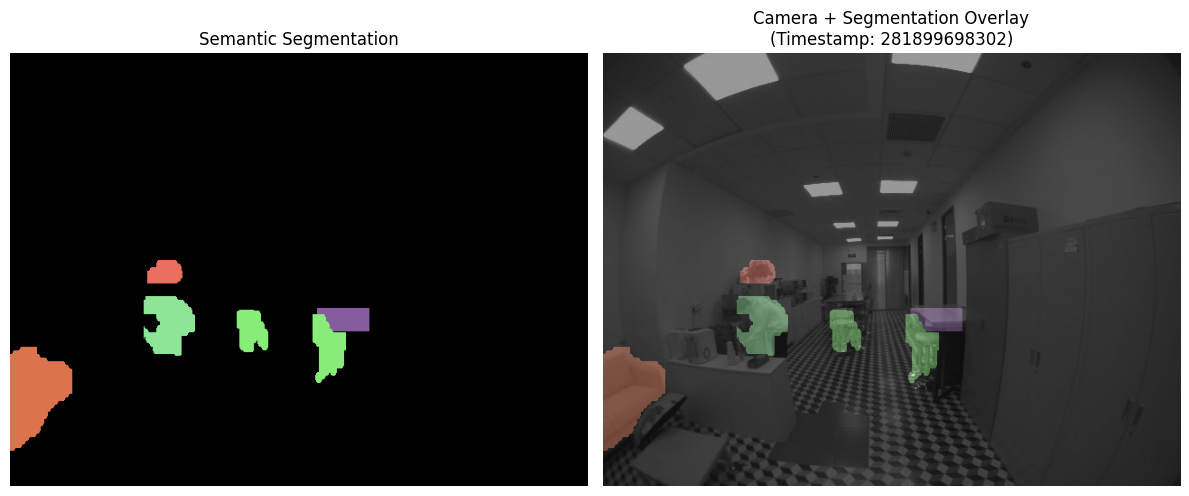

In [127]:
if not (sdk.is_connected() and hasattr(sdk, 'enhanced_imaging')):
    print("❌ Enhanced Imaging not available")
else:
    try:
        print("🧠 Capturing semantic segmentation...")
        
        # Get label information
        try:
            label_info = sdk.enhanced_imaging.get_semantic_segmentation_labels()
            label_set_name = sdk.enhanced_imaging.get_semantic_segmentation_label_set_name()
            print(f"🏷️ Model: {label_set_name} ({label_info.label_count} classes)")
        except Exception as e:
            print(f"⚠️ Could not get label info: {e}")
            label_info = None
        
        # Wait for segmentation frame
        if sdk.enhanced_imaging.wait_semantic_segmentation_next_frame(5000):
            seg_frame = sdk.enhanced_imaging.peek_semantic_segmentation_frame()
            if seg_frame:
                print(f"✅ Segmentation frame: {seg_frame.width}x{seg_frame.height}")
                
                # Import utility functions from SDK
                from slamtec_aurora_sdk.utils import to_numpy_segmentation_map, get_colorized_segmentation, generate_class_colors
                
                # Get segmentation map and colorized version
                seg_map = to_numpy_segmentation_map(seg_frame)
                
                if label_info:
                    colors = generate_class_colors(label_info.label_count)
                    colorized_seg = get_colorized_segmentation(seg_frame, colors)
                else:
                    colorized_seg = cv2.applyColorMap((seg_map * 10).astype(np.uint8), cv2.COLORMAP_TAB20)
                
                # Get camera preview image based on segmentation frame timestamp
                camera_image = None
                try:
                    # Use the segmentation frame's timestamp to get corresponding preview image
                    left_img, right_img = sdk.data_provider.get_camera_preview(seg_frame.timestamp_ns)
                    if left_img and left_img.has_image_data():
                        camera_image = left_img.to_opencv_image()
                        if len(camera_image.shape) == 2:
                            camera_image = cv2.cvtColor(camera_image, cv2.COLOR_GRAY2BGR)
                        elif len(camera_image.shape) == 3 and camera_image.shape[2] == 1:
                            camera_image = cv2.cvtColor(camera_image, cv2.COLOR_GRAY2BGR)
                        print(f"✅ Got timestamp-correlated preview image")
                    else:
                        print("⚠️ No preview image available for segmentation timestamp")
                except Exception as e:
                    print(f"⚠️ Could not get timestamp-correlated preview: {e}")
                    # Fallback to current preview if timestamp correlation fails
                    try:
                        left_img, right_img = sdk.data_provider.get_camera_preview()
                        if left_img and left_img.has_image_data():
                            camera_image = left_img.to_opencv_image()
                            if len(camera_image.shape) == 2:
                                camera_image = cv2.cvtColor(camera_image, cv2.COLOR_GRAY2BGR)
                            print("⚠️ Using current preview as fallback")
                    except Exception as fallback_e:
                        print(f"⚠️ Fallback to current preview also failed: {fallback_e}")
                
                # Create simple overlay
                overlay_image = None
                if camera_image is not None and colorized_seg is not None:
                    camera_resized = cv2.resize(camera_image, (colorized_seg.shape[1], colorized_seg.shape[0]))
                    overlay_image = cv2.addWeighted(camera_resized, 0.6, colorized_seg, 0.4, 0)
                
                unique_labels = np.unique(seg_map)
                print(f"📊 Detected {len(unique_labels)} classes: {list(unique_labels)}")
                
                # Simple visualization
                if MATPLOTLIB_AVAILABLE and colorized_seg is not None:
                    if overlay_image is not None:
                        # Two panels: segmentation + overlay
                        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                        
                        ax1.imshow(cv2.cvtColor(colorized_seg, cv2.COLOR_BGR2RGB))
                        ax1.set_title('Semantic Segmentation')
                        ax1.axis('off')
                        
                        ax2.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
                        ax2.set_title(f'Camera + Segmentation Overlay\n(Timestamp: {seg_frame.timestamp_ns})')
                        ax2.axis('off')
                    else:
                        # Single panel: segmentation only
                        plt.figure(figsize=(8, 6))
                        plt.imshow(cv2.cvtColor(colorized_seg, cv2.COLOR_BGR2RGB))
                        plt.title('Semantic Segmentation')
                        plt.axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                
                # Store for later use
                current_seg_frame = seg_frame
                current_seg_map = seg_map
                current_label_info = label_info
                
    except Exception as e:
        print(f"❌ Segmentation capture error: {e}")

## Step 5: Alternative Segmentation Models

Aurora supports multiple segmentation models optimized for different scenarios. Let's explore switching between models and comparing their outputs.

🔄 Exploring Alternative Segmentation Models...
Current model: Default
🏷️ Current Model: coco80 (81 classes)

📷 Capturing with current model...
✅ Current model - 2 classes detected: [np.uint8(0), np.uint8(3)]

🔄 Switching to alternative segmentation model...
🔄 Requested switch to alternative model...
✅ Successfully switched to alternative model
⏳ Waiting 1 second for model to stabilize...
🔄 Refetching model information...
🏷️ Switched Model: cityscapes (19 classes)
📷 Capturing with switched model...
✅ Switched model - 6 classes detected: [np.uint8(0), np.uint8(2), np.uint8(5), np.uint8(8), np.uint8(10), np.uint8(13)]


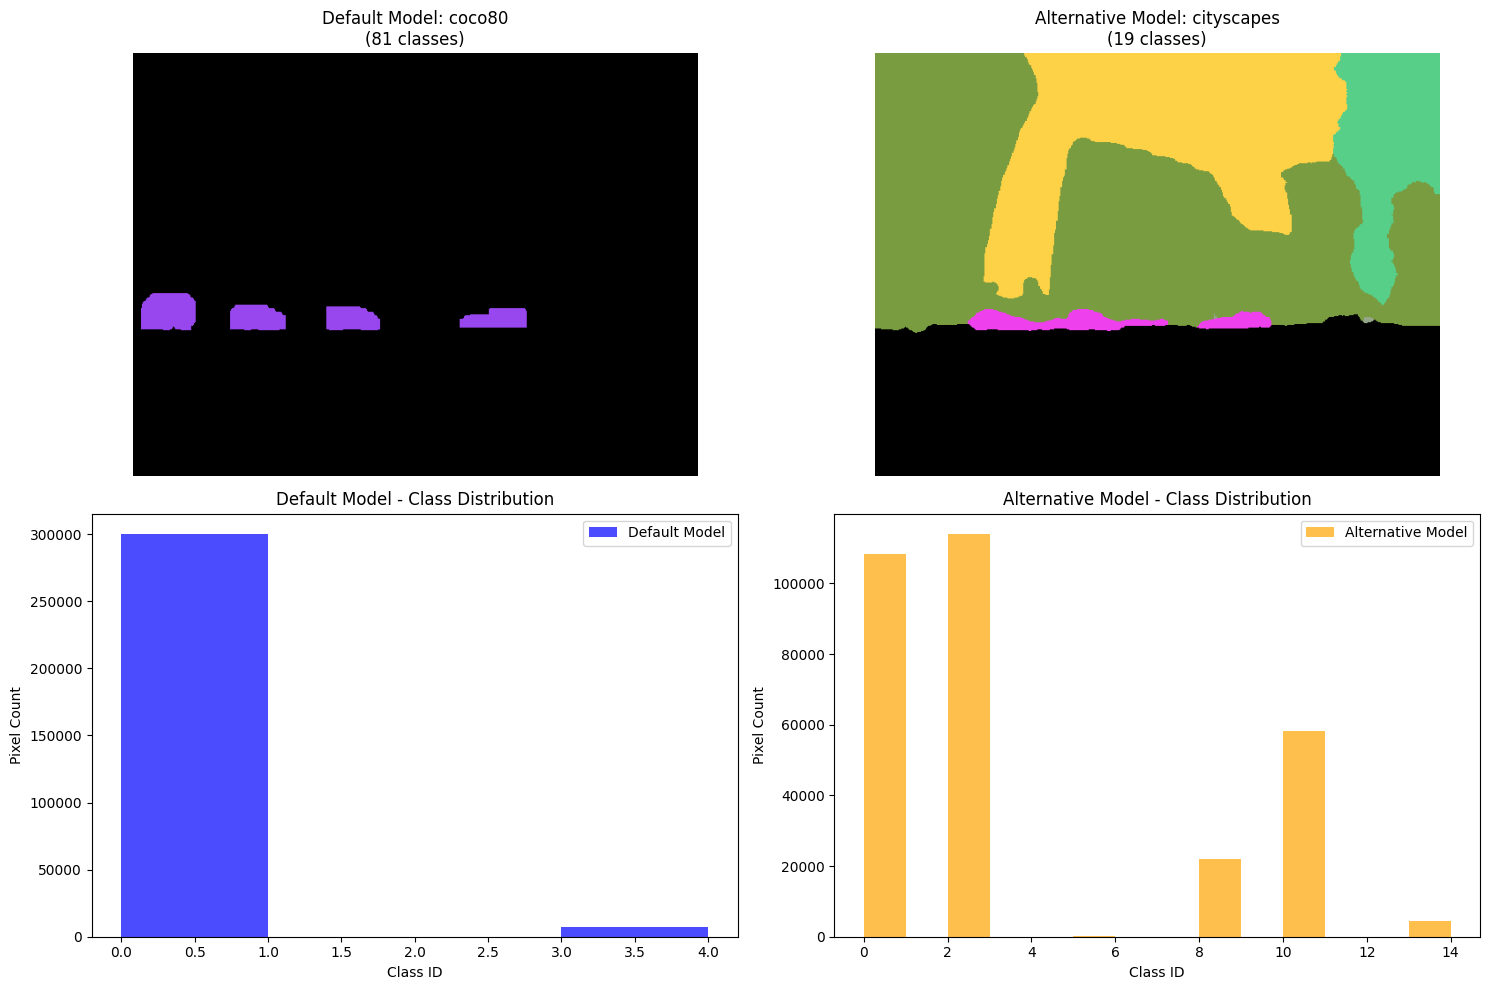


✅ Model exploration completed!
   Original: Default (coco80) - 2 classes
   Switched: Alternative (cityscapes) - 6 classes
   Switch successful: ✅


In [42]:
if not (sdk.is_connected() and hasattr(sdk, 'enhanced_imaging')):
    print("❌ Enhanced Imaging not available")
else:
    try:
        print("🔄 Exploring Alternative Segmentation Models...")
        
        # Check current model
        current_model = sdk.enhanced_imaging.is_semantic_segmentation_alternative_model()
        print(f"Current model: {'Alternative' if current_model else 'Default'}")
        
        # Get current model info
        try:
            current_label_info = sdk.enhanced_imaging.get_semantic_segmentation_labels()
            current_label_set = sdk.enhanced_imaging.get_semantic_segmentation_label_set_name()
            print(f"🏷️ Current Model: {current_label_set} ({current_label_info.label_count} classes)")
        except Exception as e:
            print(f"⚠️ Could not get current model info: {e}")
            current_label_info = None
            current_label_set = "Unknown"
        
        # Capture with current model
        print("\n📷 Capturing with current model...")
        current_seg_frame = None
        current_seg_map = None
        current_colorized = None
        
        if sdk.enhanced_imaging.wait_semantic_segmentation_next_frame(5000):
            current_seg_frame = sdk.enhanced_imaging.peek_semantic_segmentation_frame()
            if current_seg_frame:
                from slamtec_aurora_sdk.utils import to_numpy_segmentation_map, get_colorized_segmentation, generate_class_colors
                
                current_seg_map = to_numpy_segmentation_map(current_seg_frame)
                if current_label_info:
                    current_colors = generate_class_colors(current_label_info.label_count)
                    current_colorized = get_colorized_segmentation(current_seg_frame, current_colors)
                else:
                    # Fallback coloring
                    unique_labels = np.unique(current_seg_map)
                    num_classes = len(unique_labels)
                    current_colors = generate_class_colors(num_classes)
                    current_colorized = get_colorized_segmentation(current_seg_frame, current_colors)
                
                current_classes = np.unique(current_seg_map)
                print(f"✅ Current model - {len(current_classes)} classes detected: {list(current_classes)}")
        
        # Try to switch to alternative model
        target_alternative = not current_model
        target_model_name = "alternative" if target_alternative else "default"
        print(f"\n🔄 Switching to {target_model_name} segmentation model...")
        
        switch_success = False
        switched_seg_frame = None
        switched_seg_map = None
        switched_colorized = None
        switched_label_info = None
        switched_label_set = "Unknown"
        
        try:
            # Request model switch
            sdk.controller.require_semantic_segmentation_alternative_model(target_alternative)
            print(f"🔄 Requested switch to {target_model_name} model...")
            
            # Wait for model switch with timeout
            timeout_count = 0
            max_timeout = 50  # 5 seconds
            while timeout_count < max_timeout:
                current_state = sdk.enhanced_imaging.is_semantic_segmentation_alternative_model()
                if current_state == target_alternative:
                    break
                time.sleep(0.1)
                timeout_count += 1
            
            if timeout_count >= max_timeout:
                print("⚠️ Model switch timeout - alternative model may not be available")
            else:
                actual_model = sdk.enhanced_imaging.is_semantic_segmentation_alternative_model()
                actual_model_name = "alternative" if actual_model else "default"
                print(f"✅ Successfully switched to {actual_model_name} model")
                switch_success = True
                
                # Wait for model to stabilize
                print("⏳ Waiting 1 second for model to stabilize...")
                time.sleep(1.0)
                
                # Refetch model information after switch
                print("🔄 Refetching model information...")
                try:
                    switched_label_info = sdk.enhanced_imaging.get_semantic_segmentation_labels()
                    switched_label_set = sdk.enhanced_imaging.get_semantic_segmentation_label_set_name()
                    print(f"🏷️ Switched Model: {switched_label_set} ({switched_label_info.label_count} classes)")
                except Exception as e:
                    print(f"⚠️ Could not get switched model info: {e}")
                    switched_label_info = None
                
                # Capture with switched model
                print("📷 Capturing with switched model...")
                if sdk.enhanced_imaging.wait_semantic_segmentation_next_frame(5000):
                    switched_seg_frame = sdk.enhanced_imaging.peek_semantic_segmentation_frame()
                    if switched_seg_frame:
                        switched_seg_map = to_numpy_segmentation_map(switched_seg_frame)
                        
                        if switched_label_info:
                            switched_colors = generate_class_colors(switched_label_info.label_count)
                            switched_colorized = get_colorized_segmentation(switched_seg_frame, switched_colors)
                        else:
                            # Fallback coloring if label info is not available
                            unique_labels = np.unique(switched_seg_map)
                            num_classes = len(unique_labels)
                            switched_colors = generate_class_colors(num_classes)
                            switched_colorized = get_colorized_segmentation(switched_seg_frame, switched_colors)
                        
                        switched_classes = np.unique(switched_seg_map)
                        print(f"✅ Switched model - {len(switched_classes)} classes detected: {list(switched_classes)}")
                    else:
                        print("⚠️ Failed to get segmentation frame after switch")
                else:
                    print("⚠️ Timeout waiting for segmentation frame after switch")
                
        except Exception as e:
            print(f"⚠️ Model switch failed: {e}")
            print("📋 This device may not support alternative segmentation models")
        
        # Visualize model comparison
        if MATPLOTLIB_AVAILABLE and current_colorized is not None:
            if switched_colorized is not None and switch_success:
                # Side-by-side comparison
                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
                
                # Current model (before switch)
                ax1.imshow(cv2.cvtColor(current_colorized, cv2.COLOR_BGR2RGB))
                current_model_type = "Alternative" if current_model else "Default"
                ax1.set_title(f'{current_model_type} Model: {current_label_set}\n({current_label_info.label_count if current_label_info else "Unknown"} classes)')
                ax1.axis('off')
                
                # Switched model
                ax2.imshow(cv2.cvtColor(switched_colorized, cv2.COLOR_BGR2RGB))
                switched_model_type = "Alternative" if target_alternative else "Default"
                ax2.set_title(f'{switched_model_type} Model: {switched_label_set}\n({switched_label_info.label_count if switched_label_info else len(np.unique(switched_seg_map))} classes)')
                ax2.axis('off')
                
                # Class distribution comparison
                ax3.hist(current_seg_map.flatten(), bins=range(int(current_seg_map.max())+2), 
                        alpha=0.7, label=f'{current_model_type} Model', color='blue')
                ax3.set_xlabel('Class ID')
                ax3.set_ylabel('Pixel Count')
                ax3.set_title(f'{current_model_type} Model - Class Distribution')
                ax3.legend()
                
                ax4.hist(switched_seg_map.flatten(), bins=range(int(switched_seg_map.max())+2),
                        alpha=0.7, label=f'{switched_model_type} Model', color='orange')
                ax4.set_xlabel('Class ID')
                ax4.set_ylabel('Pixel Count')
                ax4.set_title(f'{switched_model_type} Model - Class Distribution')
                ax4.legend()
                
                plt.tight_layout()
                plt.show()
                
            else:
                # Only one model available or switch failed
                plt.figure(figsize=(8, 6))
                plt.imshow(cv2.cvtColor(current_colorized, cv2.COLOR_BGR2RGB))
                current_model_type = "Alternative" if current_model else "Default"
                plt.title(f'{current_model_type} Model: {current_label_set}\n({current_label_info.label_count if current_label_info else "Unknown"} classes)')
                plt.axis('off')
                plt.show()
                
                if not switch_success:
                    print("📋 Alternative model switching not available on this device")
                else:
                    print("📋 Alternative model switch succeeded but capture failed")
        
        # Store results
        model_comparison_results = {
            'original_model': current_label_set,
            'original_model_type': "Alternative" if current_model else "Default",
            'original_classes': len(np.unique(current_seg_map)) if current_seg_map is not None else 0,
            'switch_successful': switch_success,
            'switched_model': switched_label_set if switch_success else 'N/A',
            'switched_model_type': "Alternative" if target_alternative else "Default" if switch_success else 'N/A',
            'switched_classes': len(np.unique(switched_seg_map)) if switched_seg_map is not None else 0
        }
        
        print(f"\n✅ Model exploration completed!")
        print(f"   Original: {model_comparison_results['original_model_type']} ({model_comparison_results['original_model']}) - {model_comparison_results['original_classes']} classes")
        if switch_success:
            print(f"   Switched: {model_comparison_results['switched_model_type']} ({model_comparison_results['switched_model']}) - {model_comparison_results['switched_classes']} classes")
            print(f"   Switch successful: ✅")
        else:
            print(f"   Model switching: ❌ Not available or failed")
        
    except Exception as e:
        print(f"❌ Model exploration error: {e}")
        import traceback
        traceback.print_exc()

## Step 6: Cleanup

In [128]:
# Cleanup Enhanced Imaging resources
try:
    if sdk.is_connected() and hasattr(sdk, 'enhanced_imaging'):
        print("🔄 Disabling Enhanced Imaging subscriptions...")
        
        try:
            from slamtec_aurora_sdk.data_types import ENHANCED_IMAGE_TYPE_DEPTH, ENHANCED_IMAGE_TYPE_SEMANTIC_SEGMENTATION
            
            sdk.controller.set_enhanced_imaging_subscription(ENHANCED_IMAGE_TYPE_DEPTH, False)
            sdk.controller.set_enhanced_imaging_subscription(ENHANCED_IMAGE_TYPE_SEMANTIC_SEGMENTATION, False)
            print("✅ Enhanced Imaging subscriptions disabled")
        except Exception as e:
            print(f"⚠️ Error disabling subscriptions: {e}")
        
        sdk.disconnect()
        print("✅ Disconnected from device")
    
    sdk.release()
    print("✅ SDK resources released")
    
except Exception as e:
    print(f"⚠️ Cleanup warning: {e}")

print("\n🎉 Enhanced Imaging tutorial completed!")

🔄 Disabling Enhanced Imaging subscriptions...
✅ Enhanced Imaging subscriptions disabled
✅ Disconnected from device
✅ SDK resources released

🎉 Enhanced Imaging tutorial completed!


## Summary

In this notebook, you learned the fundamentals of Aurora's Enhanced Imaging capabilities:

1. ✅ **Device Connection** - Connecting to Aurora and enabling Enhanced Imaging subscriptions
2. ✅ **Depth Maps** - Capturing AI-enhanced stereo depth maps with visualization
3. ✅ **3D Point Clouds** - Converting depth data to dense 3D point clouds
4. ✅ **Semantic Segmentation** - Real-time scene understanding using onboard DNN models
5. ✅ **Alternative Models** - Switching between segmentation models and comparing their outputs

## Key Enhanced Imaging Features

### **AI-Enhanced Depth Sensing**
- High-quality depth maps using AI-enhanced stereo vision
- Dense 3D point clouds with improved accuracy
- Real-time depth estimation at camera frame rate

### **Semantic Segmentation**
- Pixel-wise scene understanding using DNN models
- Real-time object and scene classification
- Multiple models optimized for different scenarios
- Model switching and comparison capabilities

### **Multi-Modal Data**
- Timestamp-synchronized depth and segmentation data
- Basic correlation analysis and visualization
- Foundation for advanced computer vision applications

## Alternative Segmentation Models

Aurora supports multiple segmentation models:

- **Default Model**: General-purpose scene understanding
- **Alternative Models**: Specialized for specific applications or environments
- **Model Comparison**: Side-by-side analysis of different model outputs
- **Dynamic Switching**: Runtime model selection based on requirements

## Next Steps

Continue exploring Enhanced Imaging features:

- **[Advanced Enhanced Imaging](05_advanced_enhanced_imaging.ipynb)** - Advanced multi-modal correlation, rectified camera images, and depth-based segmentation coloring
- **[VSLAM Mapping](03_vslam_mapping_and_tracking.ipynb)** - Visual SLAM with Enhanced Imaging integration

## Applications

Enhanced Imaging enables sophisticated computer vision applications:

- **Autonomous Navigation**: Object detection and avoidance with multiple model options
- **3D Scene Understanding**: Semantic mapping with model selection for specific environments
- **Safety Systems**: Real-time hazard detection using specialized models
- **Robotics**: Manipulation planning with task-specific segmentation models
- **Augmented Reality**: Context-aware content placement with scene-optimized models

Enhanced Imaging represents Aurora's cutting-edge AI-powered perception capabilities!